In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_folder = "../data"
predictions_folder = "../predictions"
train_file = os.path.join(data_folder, "train_clean.csv")
test_file = os.path.join(data_folder, "test_clean.csv")

In [3]:
all_data = pd.read_csv(train_file)

In [4]:
test_data = pd.read_csv(test_file)
X_test = test_data['signal'].values.reshape(-1, 1)

In [5]:
all_data.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [6]:
all_data.shape

(5000000, 3)

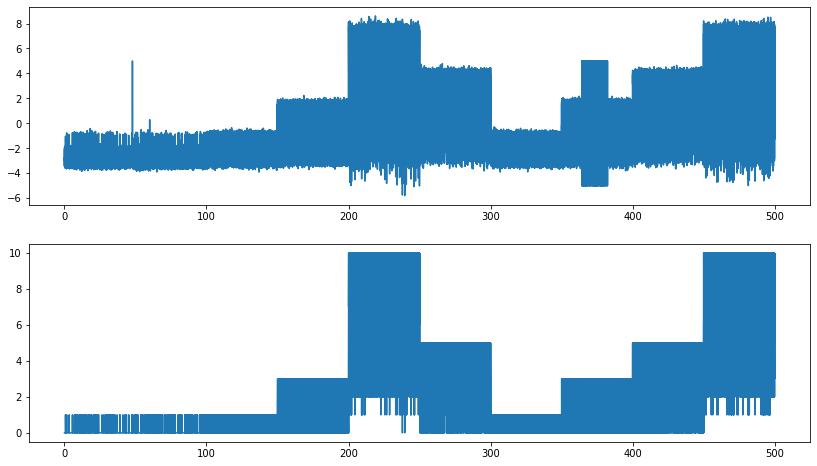

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
ax[0].plot(all_data["time"], all_data["signal"])
ax[1].plot(all_data["time"], all_data["open_channels"])

In [37]:
X = all_data['signal'].values
y = all_data['open_channels'].values

In [38]:
from sklearn.metrics import f1_score, make_scorer

def partial_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

macro_f1 = make_scorer(partial_f1_score)

In [39]:
np.random.seed(2383)
random_permutation = np.random.choice(len(X), 100000)
X_small = X[random_permutation]
y_small = y[random_permutation]

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knns_dict = {}
cv_scores = {}

for i in [150, 200, 250]:
    knns_dict[i] = KNeighborsClassifier(n_neighbors=i)
    cv_scores[i] = cross_val_score(knns_dict[i], X_small.reshape(-1,1), y_small, cv=5, scoring=macro_f1)

    print(f'i = {i} mean_score: {np.mean(cv_scores[i])}')

i = 150 mean_score: 0.7592419075414762
i = 200 mean_score: 0.75953788777368
i = 250 mean_score: 0.7597205612707375


First try at predicting test targets with a trained KNN classifier, n_neighbors = 100.

In [12]:
knn_200 = KNeighborsClassifier(n_neighbors=200)
knn_200.fit(X.reshape(-1, 1), y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [13]:
predictions = knn_200.predict(X_test)

In [14]:
predictions_df = test_data.copy(deep=True)
predictions_df['open_channels'] = predictions
predictions_df = predictions_df[['time', 'open_channels']]
predictions_df.to_csv(os.path.join(predictions_folder, "knn_200.csv"), index=False, float_format='%07.4f')

In [15]:
X_test.shape

(2000000, 1)

# Trying filtering the data

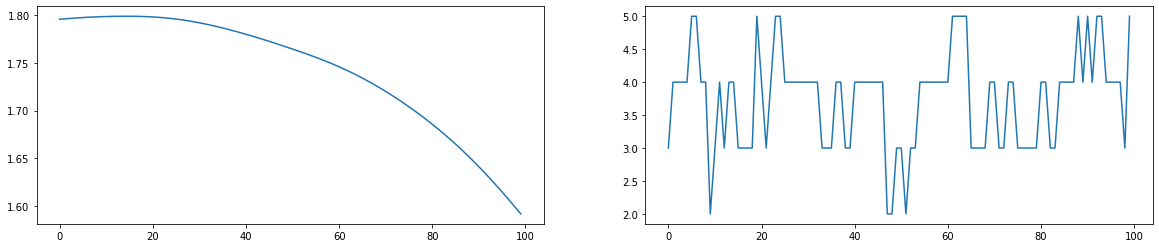

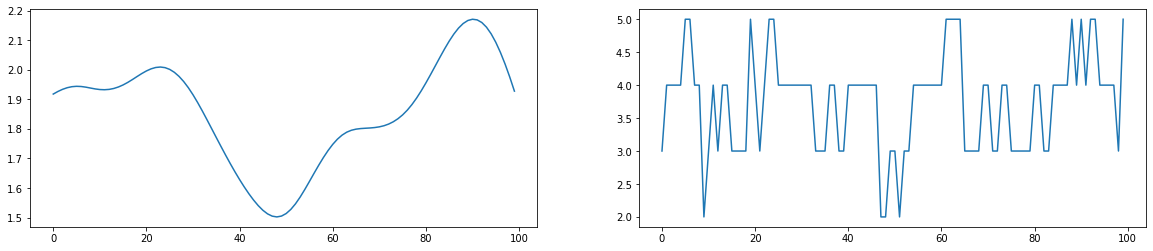

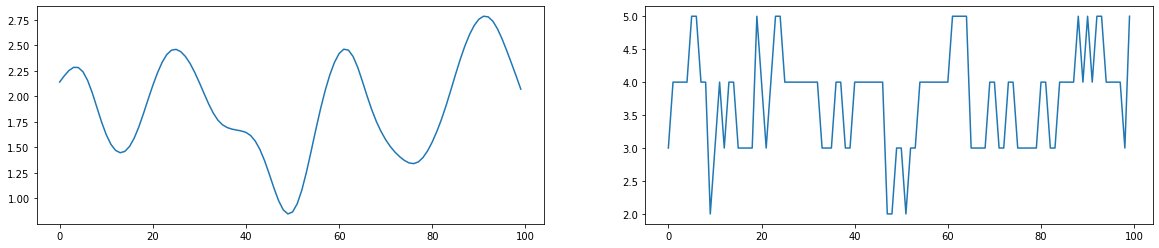

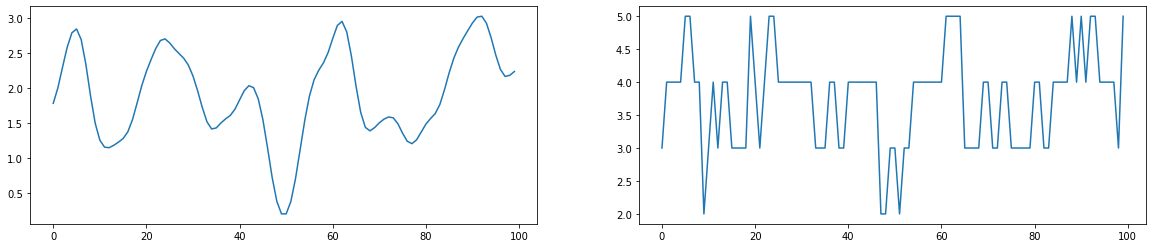

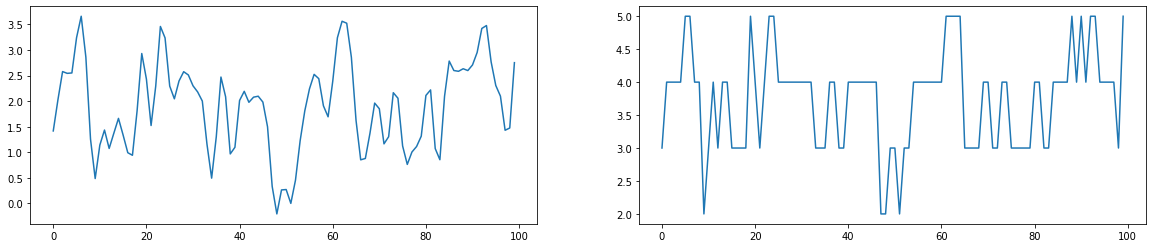

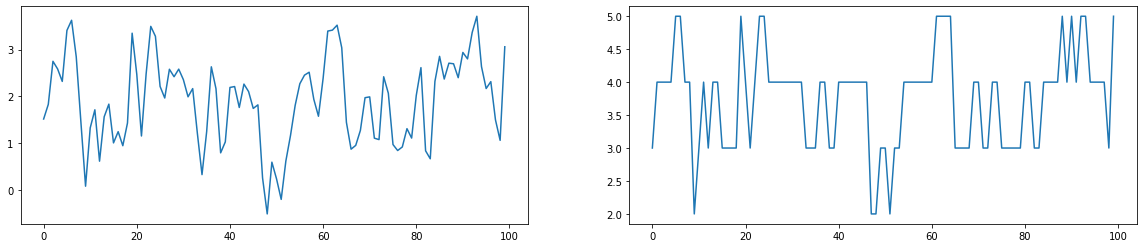

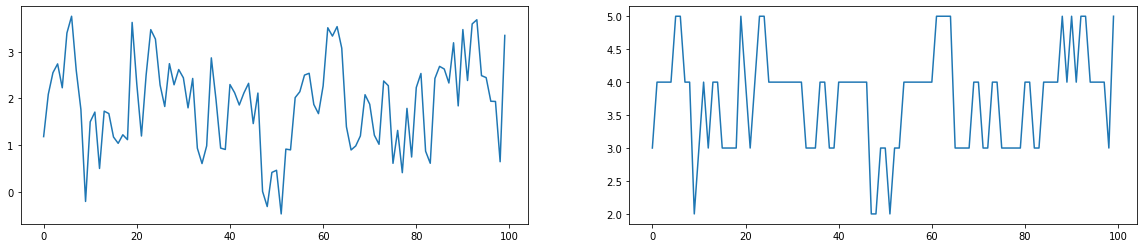

In [60]:
from filter_signal import filter_data

filtered_signal = {}
for f in [50, 200, 500, 1000, 3000, 4000, 4999]:
    filtered_signal[f] = filter_data(X, btype="low", cutoff=f)
    x_min = 4000900
    x_max = x_min+100
    z = filtered_signal[f][x_min:x_max]
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    ax[0].plot(range(len(z)), z)
    ax[1].plot(range(len(z)), y[x_min:x_max])

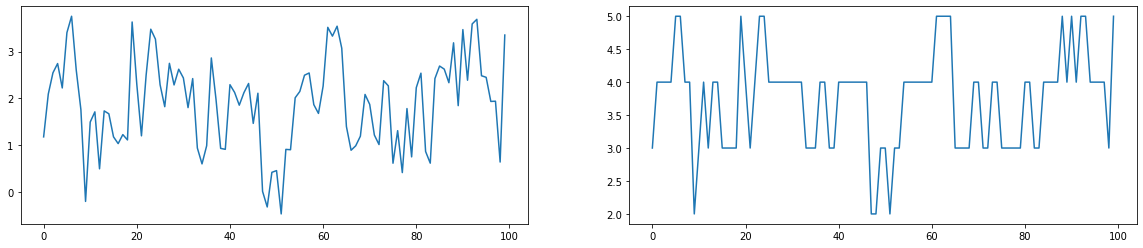

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
z = X[x_min:x_max]
ax[0].plot(range(len(z)), z)
ax[1].plot(range(len(z)), y[x_min:x_max])

In [61]:
filtered_signal[-1] = X

for f in [-1, 3000, 4000, 4999]:
    X_small = filtered_signal[f][random_permutation]
    knns_filtered = KNeighborsClassifier(n_neighbors=200, algorithm="kd_tree")
    cv_scores = cross_val_score(knns_filtered, X_small.reshape(-1,1), y_small, cv=5, scoring=macro_f1)

    print(f'cutoff freq = {f} mean_score: {np.mean(cv_scores)}')

cutoff freq = -1 mean_score: 0.75953788777368


C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cutoff freq = 3000 mean_score: 0.6764563182085572
cutoff freq = 4000 mean_score: 0.7154834118925301
cutoff freq = 4999 mean_score: 0.7586530480183251


Unfortunately it looks like low-pass filtering, even with high cutoff frequencies, removes too much information from the signal and worsens the predictions.